# Expert control to seed reinforcement learning.


This notebook is all three parts of the algorithm all the way through for the cartpole problem

<img src = "cpole.png">

In [1]:
#System Imports 
import numpy as np
from numpy import pi
import os
from matplotlib.pyplot import plot, legend, title, figure, xlabel, ylabel

#Our imports (should be in the cartpole_sim directory)

#  This is a hack...
import sys
sys.path.append("..") 

import cartpole_modules.cartpole_policy as cpp
import cartpole_modules.cartpole_sim as cps
import gym
import seagul.envs

#TensorFlow imports 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import max_norm

#Baseline (install from Github (https://github.com/openai/baselines))
from baselines.common.cmd_util import make_mujoco_env, mujoco_arg_parser
from baselines.common import tf_util as U
from baselines import logger
from baselines.ppo1 import mlp_policy, pposgd_simple

#jupyter magic
%matplotlib inline

Logging to /tmp/openai-2018-11-04-13-31-24-273463


# Heuristic Controller Data Generation

First we run a lot of simulations using the simple swingup control from different initial conditions

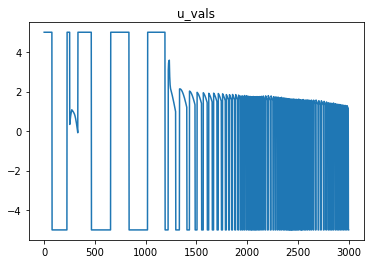

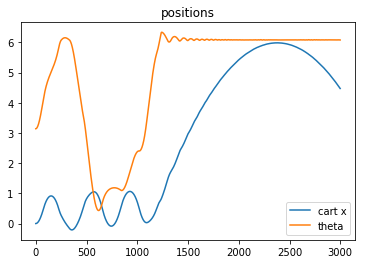

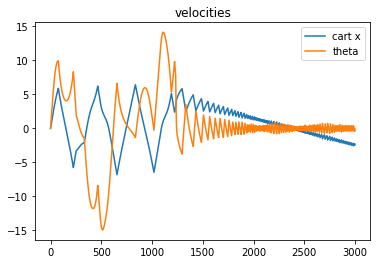

<Figure size 432x288 with 0 Axes>

In [2]:
#%%prun #comment to profile

cart = cps.CartPoleSim("cartpole.xml")

theta_vals = [pi]  # 0 is upright, pi is downwards
#theta_vals = np.linspace(pi - .3 , pi + .3,100)
#theta_vals = [pi]
#x_vals = np.linspace(-3 , 3,100)
x_vals = [0]
cart.num_steps = 3000
training_input = None
training_output = None


#cart.default_state[1][1] = pi  # 0 is upright, pi is downwards
#cart.default_state[1][1] = 0
#cart._freeze() #this stops me from being a dummy too often

# you can also change any of the gains before running the sim
cart.Kp = np.array([.1, 3])
cart.Kd = np.array([.1, .2])
cart.Ki = np.array([.2, .2])
cart.i_clip = 4
cart.total_clip = 10
cart.total_gain = 1
cart.swingup_gain = 5
cart.catch_range = .2
cart.swingup_travel = .5


for x in x_vals:
    for theta in theta_vals:
        cart.default_state[1][0] = x
        cart.default_state[1][1] = theta
        cart.run_sim()

        #if(cart.q_pos_hist[:,0].min() < -4.9 or cart.q_pos_hist[:,0].max() > 4.9 ):
        #    continue

        final_angle = cart.q_pos_hist[-1][1] % 2*pi

        #if final_angle > pi:
        #   final_angle -= 2*pi

        #if(final_angle > .4 or final_angle < -.4):
        #    continue 

        #theta = np.reshape(cart.q_pos_hist[:,1], (cart.num_steps,1))
        #pos_and_vel = np.concatenate((theta, cart.q_vel_hist), axis = 1)    
        
        
        pos_and_vel = np.concatenate((cart.q_pos_hist, cart.q_vel_hist), axis = 1)    
        u_and_zero = np.concatenate((cart.u_val_hist, np.zeros((cart.u_val_hist.size,1))), axis = 1) # don't even ask

        if training_input is None:
            training_input = pos_and_vel
            training_output = u_and_zero
        else:
            training_input = np.concatenate((training_input, pos_and_vel))
            training_output = np.concatenate((training_output, u_and_zero))

cart.plot_history()
#cart.visualize()

# Imitation Learning

Now, we use all this data to regress a simple multi layer perceptron that will serve as our policy.

<img src="mlp.jpg">

Inputs are states, outputs is supposed to be a guassian representing the control effort. However for this stage we set the variance to zero, so really the output IS just a determinsitc control effort. 

In [3]:
# create model
# This is the actual 3 layer MLP, find it as "policy" using tensorboard 
with tf.variable_scope('pi/pol/'):

    model = Sequential()
    model.add(Dense(12, input_dim=4, kernel_initializer='normal', activation='relu', name = 'fc1'))
    model.add(Dense(12,   input_dim=12, kernel_initializer='normal', activation='relu', name = 'fc2'))
    #model.add(Dense(32,   input_dim=32, kernel_initializer='normal', activation='relu', name = 'fc3'))
    model.add(Dense(2, kernel_initializer='normal', kernel_constraint=max_norm(10.), name = 'final' ))

    
# Compile model
# This adds some other stuff to your model that we don't want to consider the policy
model.compile(loss='mean_squared_error', optimizer='adam')

In [4]:
# Try this RNN, it's much cooler

look_back = 10

with tf.variable_scope('pi/pol/'):
    model = Sequential()
    model.add(LSTM(12, input_shape =(4,look_back)))
    #model.add(LSTM(4, input_shape =(12,look_back)))
    model.add(Dense(2))
    

model.compile(loss='mean_squared_error', optimizer='adam')

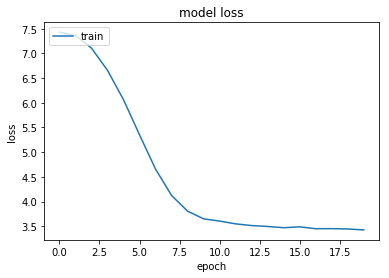

In [4]:
# you can either go ahead and fit the model or load weights, this cell will go ahead and run the fit routine

history = model.fit(training_input, training_output, epochs=20, verbose=0)

plot(history.history['loss'])
title('model loss')
ylabel('loss')
xlabel('epoch')
legend(['train', 'test'], loc='upper left')

In [ ]:
# This cell loads that we saved earlier, 
# THIS WILL OVERIDE THE RESULTS FROM ANY TRAINING YOU'VE DONE SO BE CAREFUL
# TODO, make this consistent with what you do in the cartpole policy
#model.load_weights('./100x_100epoch')

In [5]:
# This cell stores the weights, 
# Note that right now the PPO cells load their weights from here!!

pol_vars = tf.trainable_variables('pi/pol/')
saver = tf.train.Saver(pol_vars)
sess = tf.keras.backend.get_session()
saver.save(sess,'./data/supervised_weights')
#sess.graph.get_all_collection_keys()
#sess.graph.get_tensor_by_name()

'./data/supervised_weights'

## Test the MLP controller (optional)

The following cells evaluate how our supervised policy actually behaves, before the RL has it's turn.

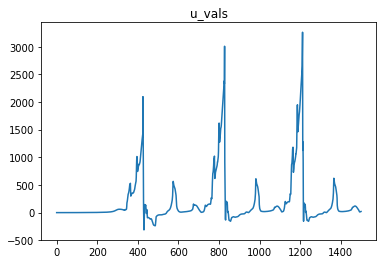

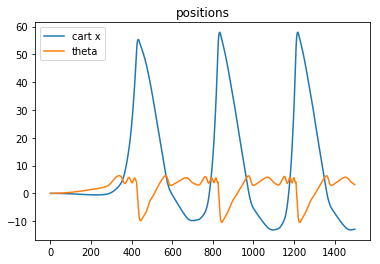

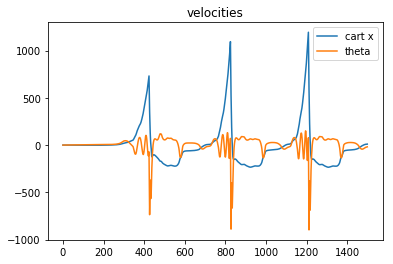

In [6]:
cart = cps.CartPoleSim("cartpole.xml")

def make_controller(model):
    def nn_controller(q_pos, q_vel):
        #return model.predict(np.reshape(np.array([q_pos[1], *q_vel]), (1,3)))[0][0] 
        return model.predict(np.reshape(np.array([*q_pos, *q_vel]), (1,4)))[0][0]    
    return nn_controller

cart.num_steps = 1500
cart.controller = make_controller(model)
cart.default_state[1][1] = 0
cart.default_state[1][0] = 0

cart.run_sim()
cart.plot_history()

In [6]:
while(True):
    cart.visualize() 

Creating window glfw


KeyboardInterrupt: 

# Reinforcement Learning (PPO)

TODO, pretty picture

In [7]:
def seeded_policy_fcn(name, ob_space, ac_space):
    return cpp.CartPolePolicy(name=name, ob_space=ob_space, ac_space=ac_space, hid_size=12, num_hid_layers=2)

def unseeded_policy_fcn(name, ob_space, ac_space):
    return mlp_policy.MlpPolicy(name=name, ob_space=ob_space, ac_space=ac_space, hid_size=6, num_hid_layers=2)


def train(env_id, policy_fcn, num_timesteps,seed=0):

    U.make_session(num_cpu=1).__enter__()
    
    env = make_mujoco_env(env_id, seed)
    pi = pposgd_simple.learn(env, policy_fcn,
            max_timesteps=num_timesteps,
            timesteps_per_actorbatch=2048,
            clip_param=0.2, entcoeff=0.0,
            optim_epochs=10, optim_stepsize=3e-4, optim_batchsize=64,
            gamma=0.99, lam=0.95, schedule='linear',
        )
    env.close()
   
    return pi

In [8]:
# This cell runs the PPO for both the seeded and the unseeded policy, right now the logs
# are put in tensorboard (so to seem them you have to run:
# tensorboard --logdir tensorboard_logs/


# TODO, tensorboard is nice but better just to get the np arrays directly back to us no?
#tf.get_default_session().close()
with tf.Graph().as_default():
    logger.configure(dir = "./tensorboard_logs/seeded_policy-tmp/", format_strs=["tensorboard"] )
    pi_seeded = train('su_cartpole-v0', 
                  policy_fcn = seeded_policy_fcn, 
                  num_timesteps=50000, 
                  seed=0)

with tf.Graph().as_default():
    logger.configure(dir = "./tensorboard_logs/unseeded_policy-tmp/", format_strs=["tensorboard"] )
    pi_unseeded = train('su_cartpole-v0', 
                    policy_fcn = unseeded_policy_fcn, 
                    num_timesteps=50000, 
                    seed=0)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./data/supervised_weights
INFO:tensorflow:Restoring parameters from ./data/supervised_weights
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [12]:
#env = make_mujoco_env('InvertedPendulum-v2',seed=0)
env = gym.make
ob = env.reset()     

# This cell evualtes the policy for the cartpole
while True:
    action = pi_unseeded.act(stochastic=False, ob=ob)[0]
    ob, _, done, _ =  env.step(action)
    env.render()
    if done:
        ob = env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("pi/Placeholder:0", shape=(), dtype=bool) is not an element of this graph.